In [7]:
# deep learning 
import tensorflow as tf 
import tensorflow.python.util.deprecation as deprecation
# import tensorflow._api.v2.compat.v1 as tf
# tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import keras.backend as K
from keras.layers import GaussianNoise, Dense, Activation, Input
from keras.models import Model

# general tools
import os
import random
import numpy as np
from tqdm import tqdm

# denoise tools
from preprocess import *
from io import *

os.chdir("..")
# check if in the main working directory
print("Current Working Directory: ", os.getcwd())

# check if eager executation is enabled: need to be disabled
print("Eager execution: {}".format(tf.executing_eagerly()))

Using TensorFlow backend.


Current Working Directory:  /Users/yufeideng/Documents/GitHub/bis687-project
Eager execution: False


## scDM: Building autoencoder architecture

In [27]:
### Activation and loss fuctions
MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)


def _nan2zero(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.math.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)

class wMSE(object):
    def __init__(self, x, type='weighted MSE'):
        self.x = x
        self.type = type
    
    def loss(self, y_true, y_pred):
        weight_loss = self.x * tf.square(y_true - y_pred)
        return weight_loss
    
class mMSE(wMSE): 
    def __init__(self, type='masked MSE', **kwds):
        super().__init__(**kwds)
        self.type = type
    
    def loss(self, y_true, y_pred):
        mask_loss = tf.sign(self.x) * tf.square(y_true - y_pred)
        return tf.reduce_mean(mask_loss)

    
class MultiNom(object):
    def __init__(self, mode='direct'):
        self.mode=mode
    
    def loss(self, y_true, y_pred):
        result = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
        return result

class IndirMultiNom(object):
    def __init__(self, pi, mode='indirect'):
        self.pi = pi
        self.mode = mode
    
    def loss(self, y_true, y_pred):
        # Compute P using y_pred(V) and pi
        P = tf.transpose(tf.transpose(self.pi * y_pred) / tf.reduce_sum(self.pi * y_pred, axis=1))
        loss = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(P, 1e-12, 1.0)))
        return loss

class NB(object):
    def __init__(self, theta=None, scale_factor=1.0, mask=False, debug=False, mean=False):
        self.eps = 1e-10
        self.scale_factor = scale_factor
        self.debug = debug
        self.mask = mask
        self.theta = theta
        self.mean = mean
    
    def loss(self, y_true, y_pred):
        mean = self.mean
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32) * self.scale_factor
        eps = self.eps
        theta = tf.minimum(self.theta, 1e6)
        
        if self.mask:
            nelem = _nelem(y_true)
            y_true = _nan2zero(y_true)
            
        t1 = tf.math.lgamma(theta + eps) + tf.math.lgamma(y_true + 1.0) - tf.math.lgamma(y_true + theta + eps)
        t2 = (theta + y_true) * tf.math.log(1.0 + (y_pred / (theta + eps))) + (y_true * (tf.math.log(theta + eps) - tf.math.log(y_pred + eps)))
        if self.debug:
            assert_ops = [tf.verify_tensor_all_finite(y_pred, 'y_pred has inf/nans'),
                        tf.verify_tensor_all_finite(t1, 't1 has inf/nans'),
                        tf.verify_tensor_all_finite(t2, 't2 has inf/nans')]
            with tf.control_dependencies(assert_ops):
                final = t1 + t2
        else:
            final = t1 + t2
        final = _nan2inf(final)
        if mean:
            if self.mask:
                final = tf.divide(tf.reduce_sum(final), nelem)
            else:
                final = tf.reduce_mean(final)
        return final

class ZINB(NB):
    # ZINB is a class representing the Zero-Inflated Negative Binomial (ZINB) loss function.
    # It is particularly useful in the context of count data or over-dispersed data.

    def __init__(self, pi, ridge_lambda=0.0, mean=True, **kwargs):
        super().__init__(mean=mean, **kwargs)
        self.pi = pi
        self.ridge_lambda = ridge_lambda
        
    def loss(self, y_true, y_pred):
        pi = self.pi
        theta = self.theta
        mean = self.mean
        eps = self.eps
        scale_factor = self.scale_factor
        
        nb_case = super().loss(y_true, y_pred) - tf.math.log(1.0 - pi + eps)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32) * scale_factor
        theta = tf.minimum(theta, 1e6)

        zero_nb = tf.pow(theta / (theta + y_pred + eps), theta)
        zero_case = -tf.math.log(pi + ((1.0 - pi) * zero_nb) + eps)
        result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
        ridge = self.ridge_lambda * tf.square(pi)
        result += ridge
        if mean:
            if self.mask:
                result = _reduce_mean(result)
            else:
                result = tf.reduce_mean(result)

        result = _nan2inf(result)
        return result

In [55]:
## Main autoencoder structure
class scDMFK():
    def __init__(self, input_size, output_size,
                dims=[64,32,64], alpha=0.001, sigma=1.0, learning_rate=0.001,
                theta=1, cluster_num=1, noise_sd=1.5, init='glorot_uniform', act='relu', adaptative = True,
                distribution='multinomial', mode='indirect'):
        # super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dims = dims
        self.cluster_num = cluster_num
        self.alpha = alpha
        self.sigma = sigma
        self.theta = theta
        self.learning_rate = learning_rate
        self.noise_sd = noise_sd
        self.init = init
        self.act = act
        self.adaptative = adaptative
        self.distribution = distribution
        self.mode = mode
        self.model = None
        self.loss = None
        self.optimizer = None
        
        # print("Creating new scDMFK model")
        # input layer
        self.x =  Input(shape=(self.input_size,), name='original')
        self.x_count = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')

        # latent layers
        self.h = self.x_count
        self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)
        for i, hid_size in enumerate(self.dims):
            center_idx = int(np.floor(len(self.dims) / 2.0))
            if i == center_idx:
                layer_name = 'hidden'
                self.latent = Dense(units=hid_size, kernel_initializer=self.init,
                                    name=layer_name)(self.h)  # hidden layer, features are extracted from here
                self.h = self.latent
            elif i < center_idx:
                layer_name = 'encoder%s' % (i+1)
                self.h = Dense(units=hid_size, kernel_initializer=self.init, name=layer_name)(self.h)
                self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
                self.h = Activation(self.act)(self.h)
            else:
                layer_name = 'decoder%s' % (i-center_idx)
                self.h = Dense(units=hid_size, activation=self.act, kernel_initializer=self.init, 
                            name=layer_name)(self.h)    
        self.build_output()
        
    def build_output(self):
        
        if self.distribution == "multinomial":
            if self.mode == "indirect":                
                # output layer
                self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
                ## self.output: this one is the expected count Vij for denoising purpose!!
                self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
                self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
                self.P = tf.transpose(tf.transpose(self.pi * self.output) / tf.reduce_sum(self.pi * self.output, axis=1))
                ## pi computation as a parallel output
                # self.pi_layer = PiLayer(output_size=self.output_size, activation='sigmoid')
                # self.pi = self.pi_layer(self.h)
                multinom = IndirMultiNom(pi=self.pi)

            else:
                self.output = Dense(units=self.output_size, activation=tf.nn.softmax, kernel_initializer=self.init, name='pi')(self.h)
                multinom = MultiNom()
            self.loss = multinom.loss
            
        elif self.distribution == "ZINB":       
            self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
            self.disp = Dense(units=self.output_size, activation=DispAct, kernel_initializer=self.init, name='dispersion')(self.h)
            self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
            self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32)) 
            zinb = ZINB(pi=self.pi, theta=self.disp, ridge_lambda=1.0)
            self.loss = zinb.loss
        
        elif self.distribution == "weight mse":
            self.output = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            # self.weight_mse = weight_mse(self.x_count, self.x, self.recon_x)
            self.loss = wMSE(x=self.x).loss
        else:
            self.output = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            # self.mask_mse = mask_mse(self.x_count, self.x, self.recon_x)
            self.loss = mMSE(x=self.x).loss

        # put together full model architecture
        self.model = Model(inputs=[self.x, self.x_count, self.sf_layer], outputs=self.output)
        
        # get hidden representation: encoder output
        self.encoder = Model(inputs=self.model.input, outputs=self.model.get_layer('hidden').output)        


    def predict(self, adata, copy=False):        
        adata = adata.copy() if copy else adata

        print('Calculating reconstructions...') 
        adata.X = self.model.predict({'original': adata.raw.X,
                                    'count': adata.X,
                                    'size_factors': adata.obs.size_factors})

        print('Calculating hidden representation...')
        adata.obsm['X_hidden'] = self.encoder.predict({'original': adata.raw.X,
                                    'count': adata.X,
                                    'size_factors': adata.obs.size_factors})
        return adata if copy else None

    def write(self, adata, output_dir, colnames=None, rownames=None):  #YD added
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values if rownames is None else rownames 
        
        data_path = output_dir
        os.makedirs(data_path, exist_ok=True) 
        filename = 'results-%s.h5ad'%self.distribution
        
        adata.write(os.path.join(data_path, filename))


    def pretrain(self, adata, size_factor, batch_size=64, pretrain_epoch=100, gpu_option='0',
                tensorboard=False):
        print("Begin the pretraining...")
        
        # set seed for reproducibility
        random.seed(42)
        np.random.seed(42)
        os.environ['PYTHONHASHSEED'] = '0'
        # os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        # os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option

        # Set up the TensorFlow session with specific configurations for parallelism 
        config_ = tf.compat.v1.ConfigProto()
        config_.gpu_options.allow_growth = True
        config_.allow_soft_placement = True
        session = tf.compat.v1.Session(config=config_)
        tf.compat.v1.keras.backend.set_session(session)
        # Initialize variables
        session.run(tf.compat.v1.global_variables_initializer())
        session.run(tf.compat.v1.local_variables_initializer())    
        
        callback = []
        if tensorboard:
            logdir = os.path.join('results', 'tb', str(batch_size)+str(pretrain_epoch))
            tensorboard = TensorBoard(log_dir=logdir)    
            callback.append(tensorboard)

        self.optimizer = tf.optimizers.Adam(self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        
        inputs = {'original': adata.raw.X, 'count': adata.X , 'size_factors': size_factor}
        output = adata.raw.X[:, [name in adata.var_names for name in adata.raw.var_names]]
        
        self.losses = self.model.fit(inputs, output,
                        epochs=pretrain_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        callbacks=callback,
                        verbose=0)
        
        print("Average loss: ", np.average(self.losses.history['loss']))
    
    def print_summary(self): #autoencoder layer-level summary
        self.model.summary()
        
    def print_train_history(self, output_dir=None): #plot the training history
        import matplotlib.pyplot as plt
        %config InlineBackend.figure_format='retina'

        plt.plot(self.losses.history['loss'], label='Training Loss')
        plt.plot(self.losses.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, 'scdm-history-%s'%(self.distribution)))
        plt.show()


In [56]:
def run_scdm(adata, dataname, output_dir=None,
            methods=['multinomial','ZINB', 'weight mse','mask mse'],
            true_label=None, dims=[64,32,64], learning_rate=0.001,
            batch_size=64, pretrain_epoch=300, return_model=False):
    
    input_size = adata.n_vars
    output_size = input_size
    size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

    if true_label is None:
        true_label = adata.obs['Group'] # true cell labels
    methods = [methods] is not isinstance(methods, list)
    
    print('Processing: %s' % dataname)
    for m in methods:
        
        print('Training: %s' % m)
        model = scDMFK(input_size=input_size, output_size=output_size,
                    dims=dims, learning_rate=learning_rate, distribution=m)
        model.pretrain(adata, size_factor, batch_size=batch_size, pretrain_epoch=pretrain_epoch)
        model.predict(adata)
        if output_dir is not None:
            model.write(adata, output_dir=output_dir)
            model.print_train_history(output_dir=output_dir)
        else:
            model.print_train_history()
    return model if return_model else None

## Denoising: Read-world data

In [6]:
### Endoderm data
dataname = 'endoderm'
methods = ['multinomial','ZINB','weight mse','mask mse']
num_genes = [500, 1000, 5000, 10000]
end_label = pd.read_csv('data/endoderm/cell_label.csv').label
for n_genes in num_genes:
    dataname = '%s-%d' % (dataname, n_genes)

    data_path = dataname + '/endoderm-%s.csv' % n_genes
    output_dir = 'results/' + dataname + '-%s' % n_genes
    os.makedirs(output_dir, exist_ok=True)
    
    data = prepro(data_path, transpose=True)
    data = normalize(data)
    run_scdm(data, dataname, output_dir=None,
            methods=methods,
            true_label=end_label,
            dims=[64,32,64],
            learning_rate=0.001,
            batch_size=64, pretrain_epoch=300, 
            return_model=False)

Processing: endoderm


NameError: name 'os' is not defined

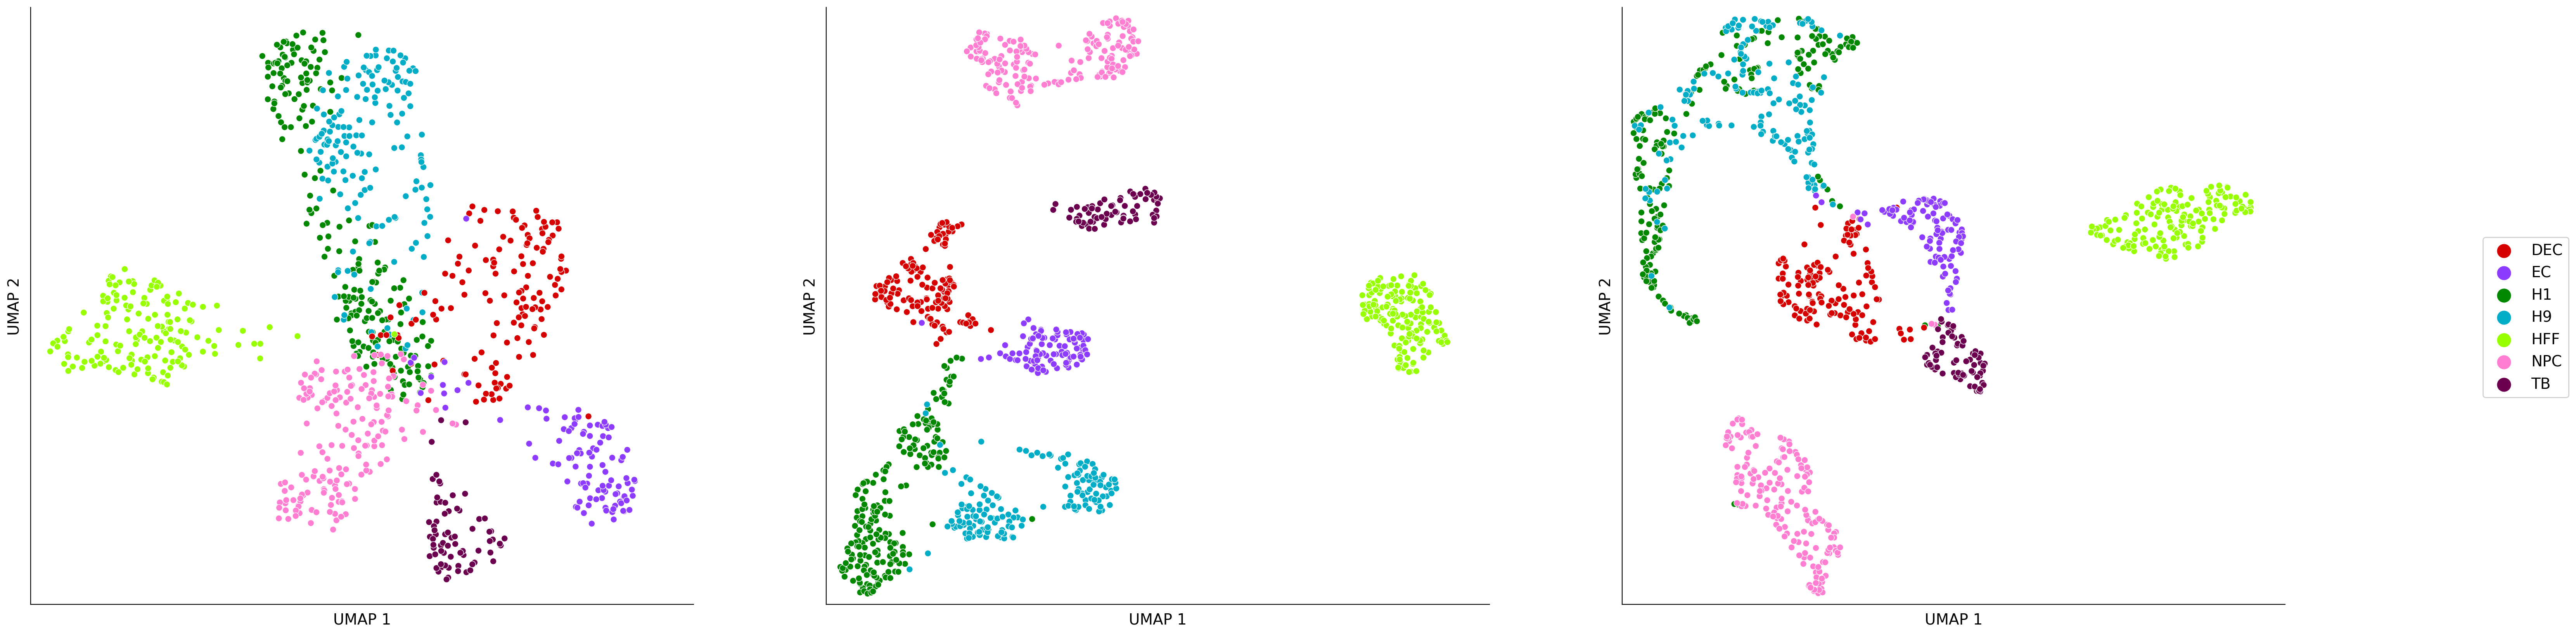

In [53]:
## true label
end_label = pd.read_csv('data/endoderm/cell_label.csv').label
end_emb = get_embedding(adata.raw.X)
end_denoise_emb = get_embedding(adata.X)
end_latent_emb = get_embedding(adata.obsm['X_hidden'])

draw_multiple_umap([end_emb,end_denoise_emb,end_latent_emb], end_label)

In [ ]:
### Young
dataname = 'Young'
transpose=False
methods = ['multinomial','ZINB']#'weight mse','mask mse']
data_path = dataname + '/data.h5'

data = prepro(data_path, transpose=transpose)
data

Successfully preprocessed 33658 genes and 5685 cells


AnnData object with n_obs × n_vars = 5685 × 33658
    obs: 'Group'

Successfully preprocessed 33658 genes and 5685 cells


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)


Selected 25215 genes and 5685 cells
Processing: Young
Training: multinomial
Begin the pretraining...
Train on 5116 samples, validate on 569 samples
Epoch 1/100


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5116/5116 - 18s - loss: 2.2343 - val_loss: 2.7610
Epoch 2/100
5116/5116 - 15s - loss: 2.0073 - val_loss: 2.7153
Epoch 3/100
5116/5116 - 27s - loss: 1.9572 - val_loss: 2.6686
Epoch 4/100
5116/5116 - 17s - loss: 1.9436 - val_loss: 2.5709
Epoch 5/100
5116/5116 - 14s - loss: 1.8999 - val_loss: 2.5478
Epoch 6/100
5116/5116 - 10s - loss: 1.8898 - val_loss: 2.5386
Epoch 7/100
5116/5116 - 9s - loss: 1.8854 - val_loss: 2.5471
Epoch 8/100
5116/5116 - 9s - loss: 1.8800 - val_loss: 2.5328
Epoch 9/100
5116/5116 - 17s - loss: 1.8752 - val_loss: 2.5094
Epoch 10/100
5116/5116 - 16s - loss: 1.8723 - val_loss: 2.5249
Epoch 11/100
5116/5116 - 12s - loss: 1.8732 - val_loss: 2.5045
Epoch 12/100
5116/5116 - 9s - loss: 1.8712 - val_loss: 2.5113
Epoch 13/100
5116/5116 - 9s - loss: 1.8654 - val_loss: 2.5180
Epoch 14/100
5116/5116 - 9s - loss: 1.8539 - val_loss: 2.5146
Epoch 15/100
5116/5116 - 14s - loss: 1.8453 - val_loss: 2.5040
Epoch 16/100
5116/5116 - 10s - loss: 1.8451 - val_loss: 2.4984
Epoch 17/100
5116/

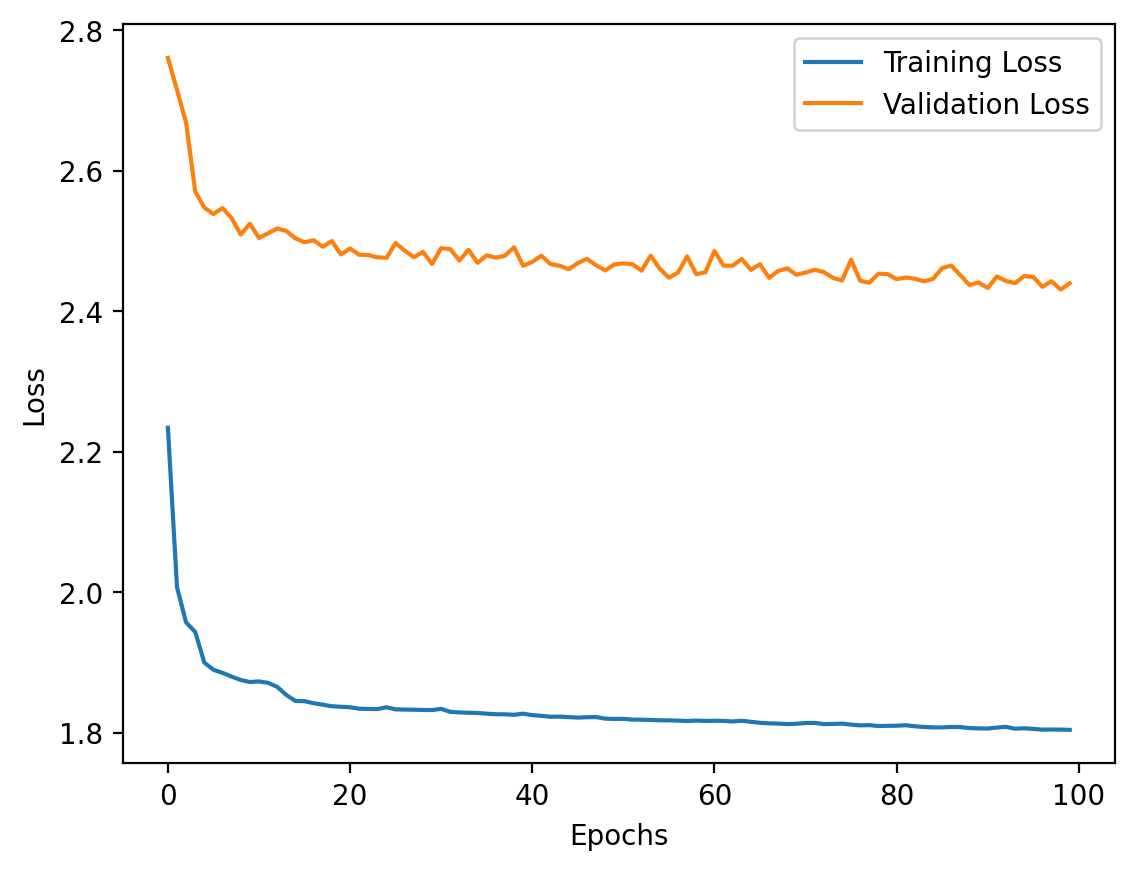

Training: ZINB
Begin the pretraining...
Train on 5116 samples, validate on 569 samples
Epoch 1/100
5116/5116 - 51s - loss: 0.3491 - val_loss: 0.3917
Epoch 2/100
5116/5116 - 35s - loss: 0.3445 - val_loss: 0.3901
Epoch 3/100
5116/5116 - 29s - loss: 0.3434 - val_loss: 0.3873
Epoch 4/100
5116/5116 - 36s - loss: 0.3417 - val_loss: 0.3865
Epoch 5/100
5116/5116 - 39s - loss: 0.3406 - val_loss: 0.3856
Epoch 6/100
5116/5116 - 35s - loss: 0.3395 - val_loss: 0.3840
Epoch 7/100
5116/5116 - 34s - loss: 0.3389 - val_loss: 0.3826
Epoch 8/100
5116/5116 - 32s - loss: 0.3383 - val_loss: 0.3819
Epoch 9/100
5116/5116 - 33s - loss: 0.3378 - val_loss: 0.3814
Epoch 10/100
5116/5116 - 33s - loss: 0.3374 - val_loss: 0.3807
Epoch 11/100
5116/5116 - 33s - loss: 0.3370 - val_loss: 0.3799
Epoch 12/100
5116/5116 - 42s - loss: 0.3366 - val_loss: 0.3798
Epoch 13/100
5116/5116 - 34s - loss: 0.3363 - val_loss: 0.3791
Epoch 14/100
5116/5116 - 34s - loss: 0.3361 - val_loss: 0.3783
Epoch 15/100
5116/5116 - 33s - loss: 0.3

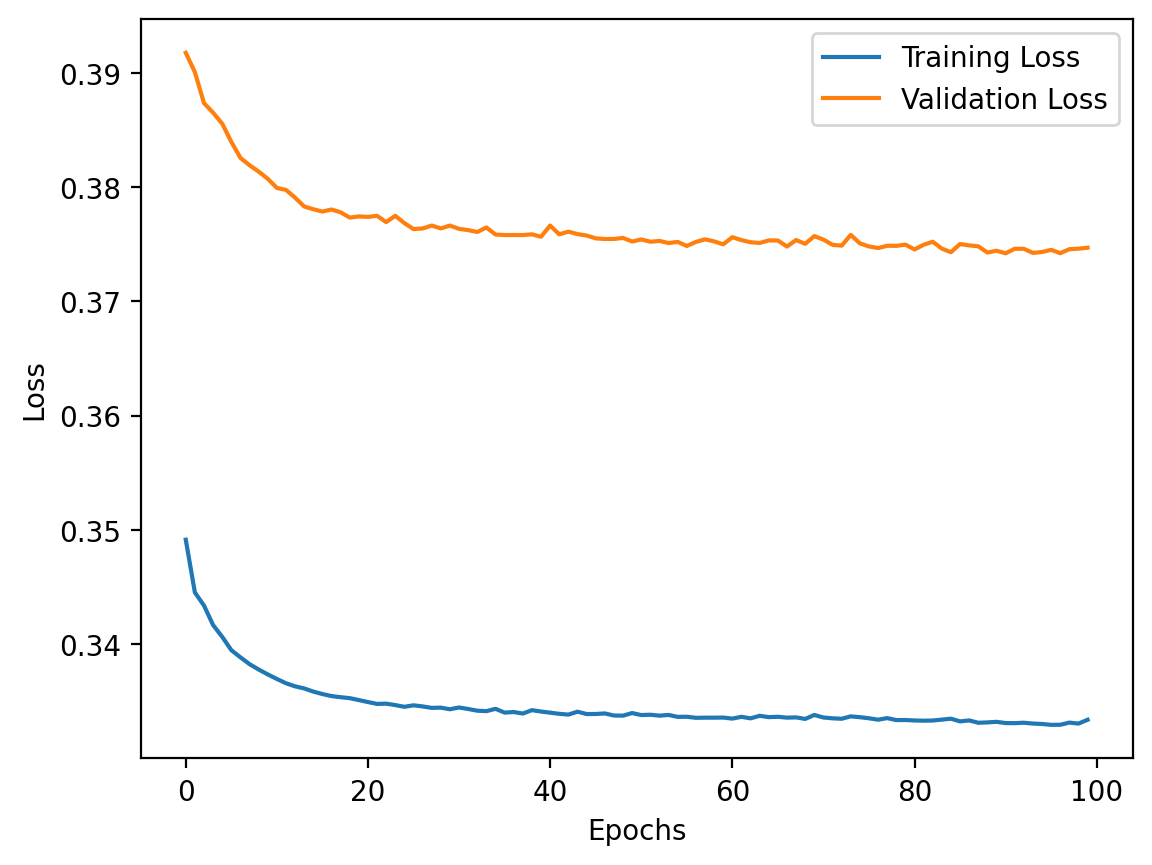

In [ ]:
### Young
run_scdm(dataname='Young', transpose=False, output_dir=None,
            methods=['multinomial','ZINB', 'weight mse','mask mse'],
            true_label=None, dims=[64,32,64], learning_rate=0.001,
            batch_size=64, pretrain_epoch=300)


In [ ]:
### Bladder
run_scdm(dataname='Bladder', transpose=False, output_dir=None,
            methods=['multinomial','ZINB', 'weight mse','mask mse'],
            true_label=None, dims=[64,32,64], learning_rate=0.001,
            batch_size=64, pretrain_epoch=300)

## Simulated data

Successfully preprocessed 200 genes and 2000 cells
Selected 199 genes and 2000 cells
Training: multinomial
Begin the pretraining...
Train on 1800 samples, validate on 200 samples
Epoch 1/500


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1800/1800 - 1s - loss: 1738.6153 - val_loss: 1594.0402
Epoch 2/500
1800/1800 - 0s - loss: 1665.9992 - val_loss: 1566.9119
Epoch 3/500
1800/1800 - 0s - loss: 1602.8746 - val_loss: 1539.2258
Epoch 4/500
1800/1800 - 0s - loss: 1541.5848 - val_loss: 1507.6125
Epoch 5/500
1800/1800 - 0s - loss: 1474.0020 - val_loss: 1470.7751
Epoch 6/500
1800/1800 - 0s - loss: 1412.4503 - val_loss: 1431.2565
Epoch 7/500
1800/1800 - 0s - loss: 1356.8302 - val_loss: 1394.4121
Epoch 8/500
1800/1800 - 0s - loss: 1313.4050 - val_loss: 1364.2739
Epoch 9/500
1800/1800 - 0s - loss: 1285.4526 - val_loss: 1342.9901
Epoch 10/500
1800/1800 - 0s - loss: 1267.7997 - val_loss: 1329.3357
Epoch 11/500
1800/1800 - 0s - loss: 1254.9132 - val_loss: 1318.9327
Epoch 12/500
1800/1800 - 0s - loss: 1246.0578 - val_loss: 1311.9065
Epoch 13/500
1800/1800 - 0s - loss: 1239.4041 - val_loss: 1306.3034
Epoch 14/500
1800/1800 - 0s - loss: 1234.6043 - val_loss: 1302.1258
Epoch 15/500
1800/1800 - 0s - loss: 1229.6012 - val_loss: 1298.5428
E

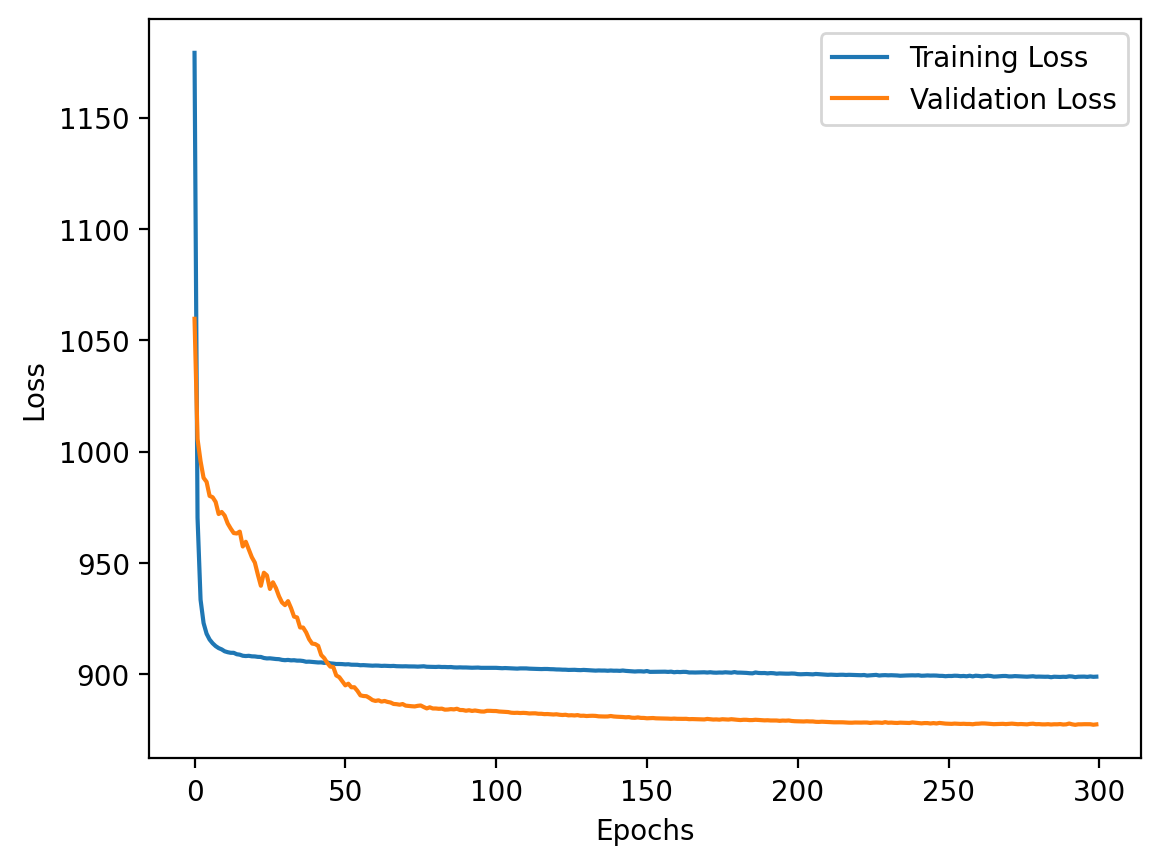

In [43]:
# 读取模拟数据
dataname = "group2_dropout1/counts.tsv"
output_dir = 'group2_dropout1'
transpose = True
adata = prepro(dataname, transpose=transpose)
adata = normalize(adata)

input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

# print原始模拟数据 （非真实值）
raw = pd.DataFrame(adata.raw.X, columns=adata.raw.var_names)[adata.var_names]
raw
print('Training: %s' % m)
multinom = scDMFK(input_size=input_size, output_size=output_size,
            dims=[64,32,64], learning_rate=0.0001, distribution="multinomial")
multinom.pretrain(adata, size_factor, batch_size=64, pretrain_epoch=500)
multinom.predict(adata)
# model.write(adata, output_dir=output_dir)
model.print_train_history(output_dir=output_dir)

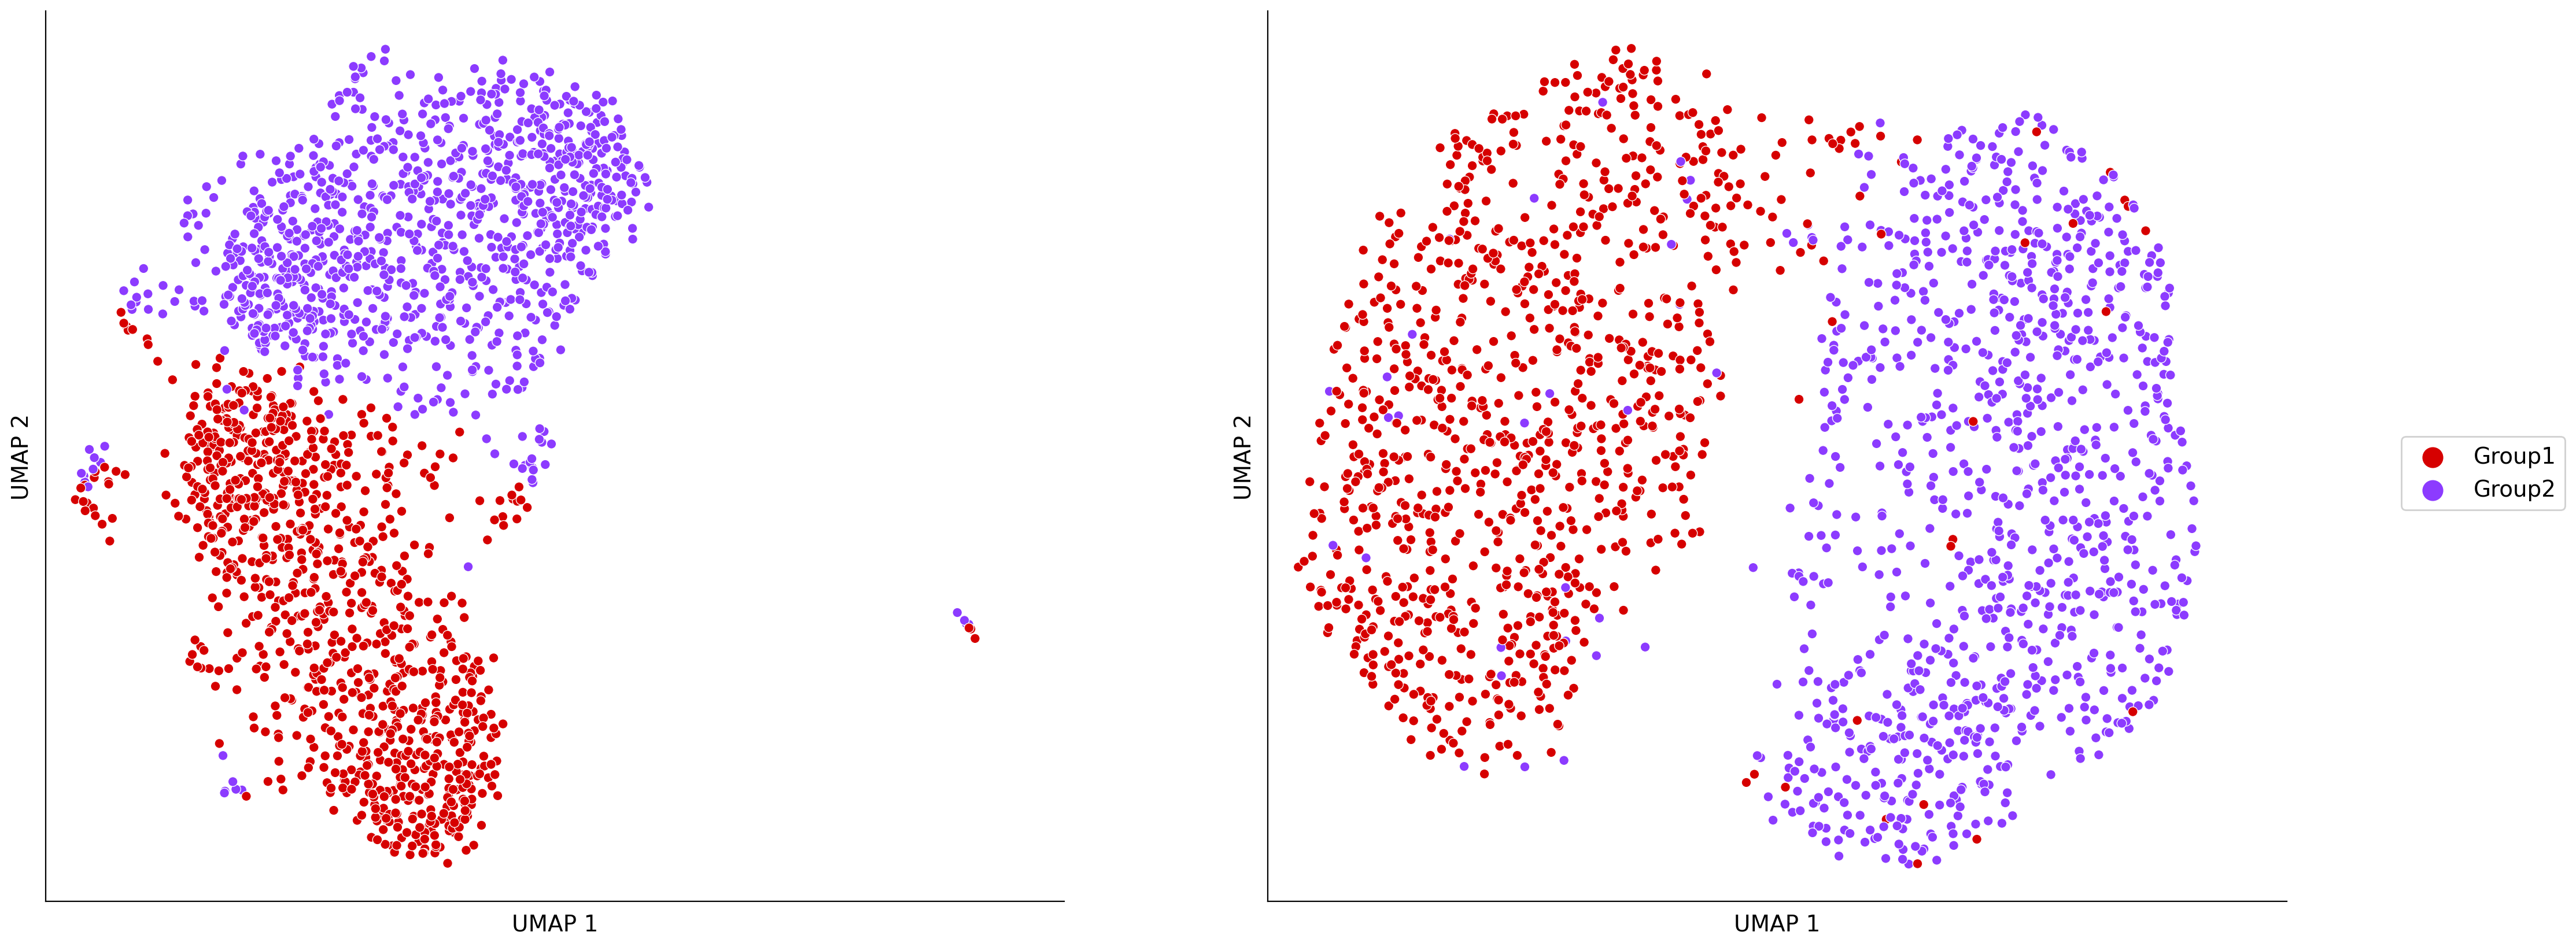

In [47]:
from scDMFK.io import *
sim_label= pd.read_csv('data/group2_dropout1/info_cellinfo.tsv', sep='\t')['Group']
## raw data
sim_emb = get_embedding(adata.raw.X)
sim_denoise_emb = get_embedding(adata.X)

draw_multiple_umap([sim_emb, sim_denoise_emb], sim_label)

Processing: group2_dropout5
Successfully preprocessed 200 genes and 2000 cells


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:237: RuntimeWarning: invalid value encountered in true_divide
  df['dispersions_norm'] = (


Selected 195 genes and 2000 cells
Training: multinomial
Begin the pretraining...
Train on 1800 samples, validate on 200 samples
Epoch 1/300


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1800/1800 - 1s - loss: 1179.1062 - val_loss: 1059.6535
Epoch 2/300
1800/1800 - 0s - loss: 970.2916 - val_loss: 1005.6439
Epoch 3/300
1800/1800 - 0s - loss: 933.5034 - val_loss: 995.7129
Epoch 4/300
1800/1800 - 0s - loss: 923.0017 - val_loss: 988.2151
Epoch 5/300
1800/1800 - 0s - loss: 918.1956 - val_loss: 986.4081
Epoch 6/300
1800/1800 - 0s - loss: 915.5802 - val_loss: 980.0954
Epoch 7/300
1800/1800 - 0s - loss: 913.9174 - val_loss: 979.5110
Epoch 8/300
1800/1800 - 0s - loss: 912.6454 - val_loss: 977.3944
Epoch 9/300
1800/1800 - 0s - loss: 911.7395 - val_loss: 971.9543
Epoch 10/300
1800/1800 - 0s - loss: 911.1614 - val_loss: 972.8838
Epoch 11/300
1800/1800 - 0s - loss: 910.3091 - val_loss: 971.2507
Epoch 12/300
1800/1800 - 0s - loss: 909.9039 - val_loss: 967.7152
Epoch 13/300
1800/1800 - 0s - loss: 909.6328 - val_loss: 965.4243
Epoch 14/300
1800/1800 - 0s - loss: 909.6202 - val_loss: 963.4217
Epoch 15/300
1800/1800 - 0s - loss: 908.9912 - val_loss: 963.2247
Epoch 16/300
1800/1800 - 0s 

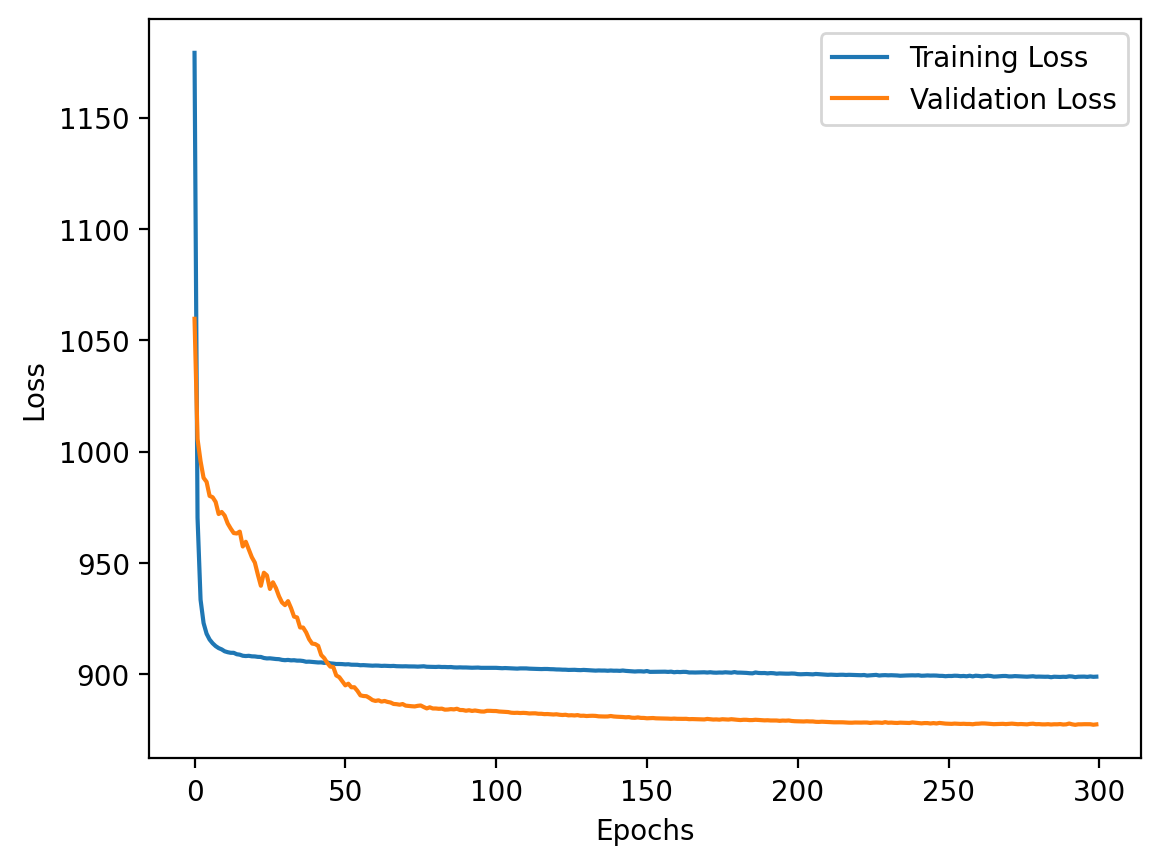

In [37]:
# load simulated data
datanames = [ 
    #TO DO: fill data folder name for simulated datasets
    # 'group2_dropout1',
    'group2_dropout5',
]
methods = ['multinomial'] #,'ZINB','weight mse','mask mse'] 

for dataname in datanames:
    print('Processing: %s' % dataname)
    data_path =dataname + '/counts.tsv'
    output_dir = 'results/' + dataname
    os.makedirs(output_dir, exist_ok=True)
    
    data = prepro(data_path, transpose=True)
    data = normalize(data)

    input_size = data.n_vars
    output_size = input_size
    size_factor = np.array(data.obs.size_factors).reshape(-1, 1).astype(np.float32)

    for m in methods:
        
        adata = data.copy()
        print('Training: %s' % m)
        model = scDMFK(input_size=input_size, output_size=output_size,
                    dims=[64,32,64], learning_rate=0.001, distribution=m)
        model.pretrain(adata, size_factor, batch_size=64, pretrain_epoch=300)
        model.predict(adata)
        print(adata.X[:4,:]) # preview denoised data
        # model.write(adata, output_dir=output_dir)
        model.print_train_history(output_dir=output_dir, save=True)

In [39]:
pd.DataFrame(adata.obsm['X_hidden'])

0          1          2         3          4          5   \
0    -1.058166  15.900344 -11.468574 -5.924759 -25.014235 -23.918131   
1    -0.189848  11.509134  -7.899107 -3.794070 -16.096884 -16.221926   
2    -1.088784  14.754175  -9.240363 -5.958412 -18.826410 -20.684763   
3    -1.183491  11.634348  -8.401369 -2.924707 -17.943089 -16.188707   
4    -0.275954  10.092144  -6.562306 -2.050138 -14.372270 -15.045667   
...        ...        ...        ...       ...        ...        ...   
1995 -0.618170   7.189879  -5.711440 -2.832631 -11.243871 -10.222225   
1996 -0.808062   9.805633  -7.130411 -4.784129 -15.326072 -14.620572   
1997 -0.021182   9.048190  -7.546503 -3.413109 -14.632742 -12.483839   
1998 -1.624859  10.428436  -8.320458 -5.256906 -16.166147 -14.701756   
1999  0.951600   8.913273  -7.321548 -4.050725 -13.864459 -13.526664   

            6          7          8          9   ...         22        23  \
0    -7.747058 -38.524223  14.368256  20.560913  ... -26.005598  0.677912   
1    -5.664032 -25.232103  10.064466  14.778456  ... -17.865091  0.950235   
2    -5.969559 -29.829233  11.232594  16.081684  ... -19.985197  1.262754   
3    -4.566516 -27.075338  10.312511  15.165861  ... -19.562687  0.300336   
4    -5.022903 -22.773495   8.159709  12.019048  ... -14.353309  1.171266   
...        ...        ...        ...        ...  ...        ...       ...   
1995 -2.119082 -16.442677   7.001144   8.662874  ... -11.284739  0.565097   
1996 -3.427410 -23.702206  10.539024  12.743434  ... -15.766728  0.006369   
1997 -3.916747 -22.148228   9.343370  13.413618  ... -17.273731 -0.015839   
1998 -2.947805 -22.938412   9.639016  13.895372  ... -17.047695  1.337512   
1999 -2.310183 -20.317480   5.605661   6.783347  ... -13.949964  1.527877   

             24         25        26         27         28         29  \
0    -26.887901 -11.061806  7.545750 -24.537987 -24.114265 -13.576273   
1    -18.651649  -7.701150  6.558901 -15.692753 -15.678643 -10.134225   
2    -22.879261 -11.051083  7.514607 -19.139885 -18.785038 -11.719098   
3    -17.846441  -7.628047  6.425371 -14.324318 -16.193489 -10.956156   
4    -16.917871  -7.455256  4.594039 -14.915032 -13.708725  -8.005689   
...         ...        ...       ...        ...        ...        ...   
1995 -10.609066  -5.731751  4.036440  -8.782388 -10.242945  -6.842993   
1996 -14.382041  -7.031921  4.507413 -14.376056 -14.873754  -8.434711   
1997 -14.706049  -5.491952  6.146351 -11.666181 -13.089495  -9.939384   
1998 -16.110531  -8.402665  6.799575 -12.465004 -14.320514  -9.751603   
1999  -9.805095  -9.024305  3.354727 -11.252353 -12.135836  -6.097626   

            30        31  
0    -7.861776  4.417193  
1    -4.557890  1.022760  
2    -7.631857  0.665591  
3    -5.599022  2.510894  
4    -4.791742  2.160573  
...        ...       ...  
1995 -3.554955  1.647642  
1996 -4.586175  3.535862  
1997 -3.453519  1.083029  
1998 -5.323092  2.119756  
1999 -6.917519  4.979208  

[2000 rows x 32 columns]

In [40]:
sim5_label= pd.read_csv('data/group2_dropout5/info_cellinfo.tsv', sep='\t')['Group']
# sim5_raw = pd.read_csv('data/group2_dropout5/counts.tsv', sep='\t')# raw data
# raw clustering
sim5_emb = get_embedding(adata.raw.X)
sim5_multinom_emb = get_embedding(adata.X)
draw_multiple_umap([sim5_emb,sim5_multinom_emb], sim_label)

NameError: name 'get_embedding' is not defined

## UMAP Clustering: Endoderm data

In [11]:
from scDMFK.io import get_embedding, draw_umap
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
## Let's rerun the model with the best model setting from previous hyperparam search:
# load endoderm data
dataname = "endoderm/endoderm.csv"
output_dir = None
transpose = True
highly_genes = None
highly_subset=False
adata = prepro(dataname, transpose=transpose)

adata = normalize(adata, highly_genes=highly_genes, highly_subset=highly_subset)
high_variable = adata.var.highly_variable

input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

best_model = scDMFK(input_size, output_size, dims=[64,32,64], learning_rate=0.001)
best_model.pretrain(adata, size_factor, batch_size=64, pretrain_epoch=100)
best_model.predict(adata)
# # model.write(adata)
endoderm_scdm = pd.DataFrame(adata.X, 
                    index=adata.obs_names,
                    columns=adata.var_names) #* adata.raw.X.sum(1)[:,np.newaxis]
endoderm_scdm

Successfully preprocessed 19097 genes and 1018 cells
Begin the pretraining...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Average loss:  2120.6221044681934
Calculating reconstructions...
Calculating hidden representation...


MKL2        CD109     ABTB1     MAST2       KAT5  \
H1_Exp1.001    25.868992    24.628611  0.500580  3.711763  25.867853   
H1_Exp1.002    39.537540    34.038826  0.820183  6.621381  39.536236   
H1_Exp1.003    31.136253    38.331810  0.576892  4.930996  31.135077   
H1_Exp1.004    24.128023    22.504652  0.525999  3.650322  24.127234   
H1_Exp1.006    20.576384    23.964817  0.407541  3.290749  20.575327   
...                  ...          ...       ...       ...        ...   
TB_Batch2.140   0.710271   756.385681  0.032660  0.355514   0.703037   
TB_Batch2.141   0.609341   573.840149  0.138675  0.246449   0.601854   
TB_Batch2.142   0.767183  1546.455078  0.115385  0.473100   0.754761   
TB_Batch2.143   1.285179  1360.060669  0.183024  0.559966   1.273408   
TB_Batch2.144   2.129017   868.255249  0.088581  0.914445   2.120528   

                     WWC2     CD163       UBE2Z      RGPD4   PHYHIPL  ...  \
H1_Exp1.001    148.303802  0.041647   50.696587  25.867226  0.538591  ...   
H1_Exp1.002    230.332581  0.088979   82.423309  39.534931  0.832700  ...   
H1_Exp1.003    176.696991  0.063124   60.847084  31.134476  0.736968  ...   
H1_Exp1.004    158.476013  0.023057   53.492165  24.126539  0.779788  ...   
H1_Exp1.006    130.000214  0.052021   53.104057  20.574680  0.408695  ...   
...                   ...       ...         ...        ...       ...  ...   
TB_Batch2.140  464.694092  0.017956  240.483719   0.709099  0.050044  ...   
TB_Batch2.141  452.363037  0.035112  224.143631   0.601455  0.062944  ...   
TB_Batch2.142  554.948975  0.008400  694.652649   0.759682  0.013068  ...   
TB_Batch2.143  446.522888  0.026447  325.945892   1.280679  0.073259  ...   
TB_Batch2.144  401.003082  0.039430  209.996353   2.127290  0.107054  ...   

                 SNRNP48     ARMC3    DUSP28       INO80       NUP205  \
H1_Exp1.001    25.869211  0.174745  0.538463   34.370800   284.121582   
H1_Exp1.002    39.537823  0.062845  1.746665   50.707733   386.723450   
H1_Exp1.003    31.136515  0.078192  0.943870   35.077103   310.881439   
H1_Exp1.004    24.128239  0.061555  1.184625   31.878557   263.441376   
H1_Exp1.006    20.576605  0.072777  0.785445   33.396225   257.100372   
...                  ...       ...       ...         ...          ...   
TB_Batch2.140   0.711214  0.001860  0.025081  164.125046   874.674744   
TB_Batch2.141   0.612789  0.013512  0.105089  264.975189  1627.703125   
TB_Batch2.142   0.770721  0.012357  0.166222  330.646484   432.857910   
TB_Batch2.143   1.287567  0.013814  0.157414  354.323517  1624.397949   
TB_Batch2.144   2.129973  0.003559  0.047443  144.241608  1245.479614   

                     WDR33    EPSTI1    CLPTM1L    CCDC125  CATSPER3  
H1_Exp1.001     161.133484  0.580846  25.866959  25.869074  1.587115  
H1_Exp1.002     245.593658  0.863162  39.535053  39.537663  2.076407  
H1_Exp1.003     164.029297  0.510346  31.134130  31.136398  1.920202  
H1_Exp1.004     148.408600  0.443640  24.126539  24.128132  2.093164  
H1_Exp1.006     161.937500  0.456149  20.574577  20.576477  1.245227  
...                    ...       ...        ...        ...       ...  
TB_Batch2.140   628.248840  0.265208   0.702536   0.710561  0.207562  
TB_Batch2.141   501.819550  0.211799   0.599044   0.610502  0.149327  
TB_Batch2.142  1149.007202  0.365852   0.752224   0.770877  0.102867  
TB_Batch2.143   678.177795  0.616541   1.271631   1.286250  0.375606  
TB_Batch2.144   684.826355  0.557453   2.119066   2.129246  0.369011  

[1018 rows x 18250 columns]

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


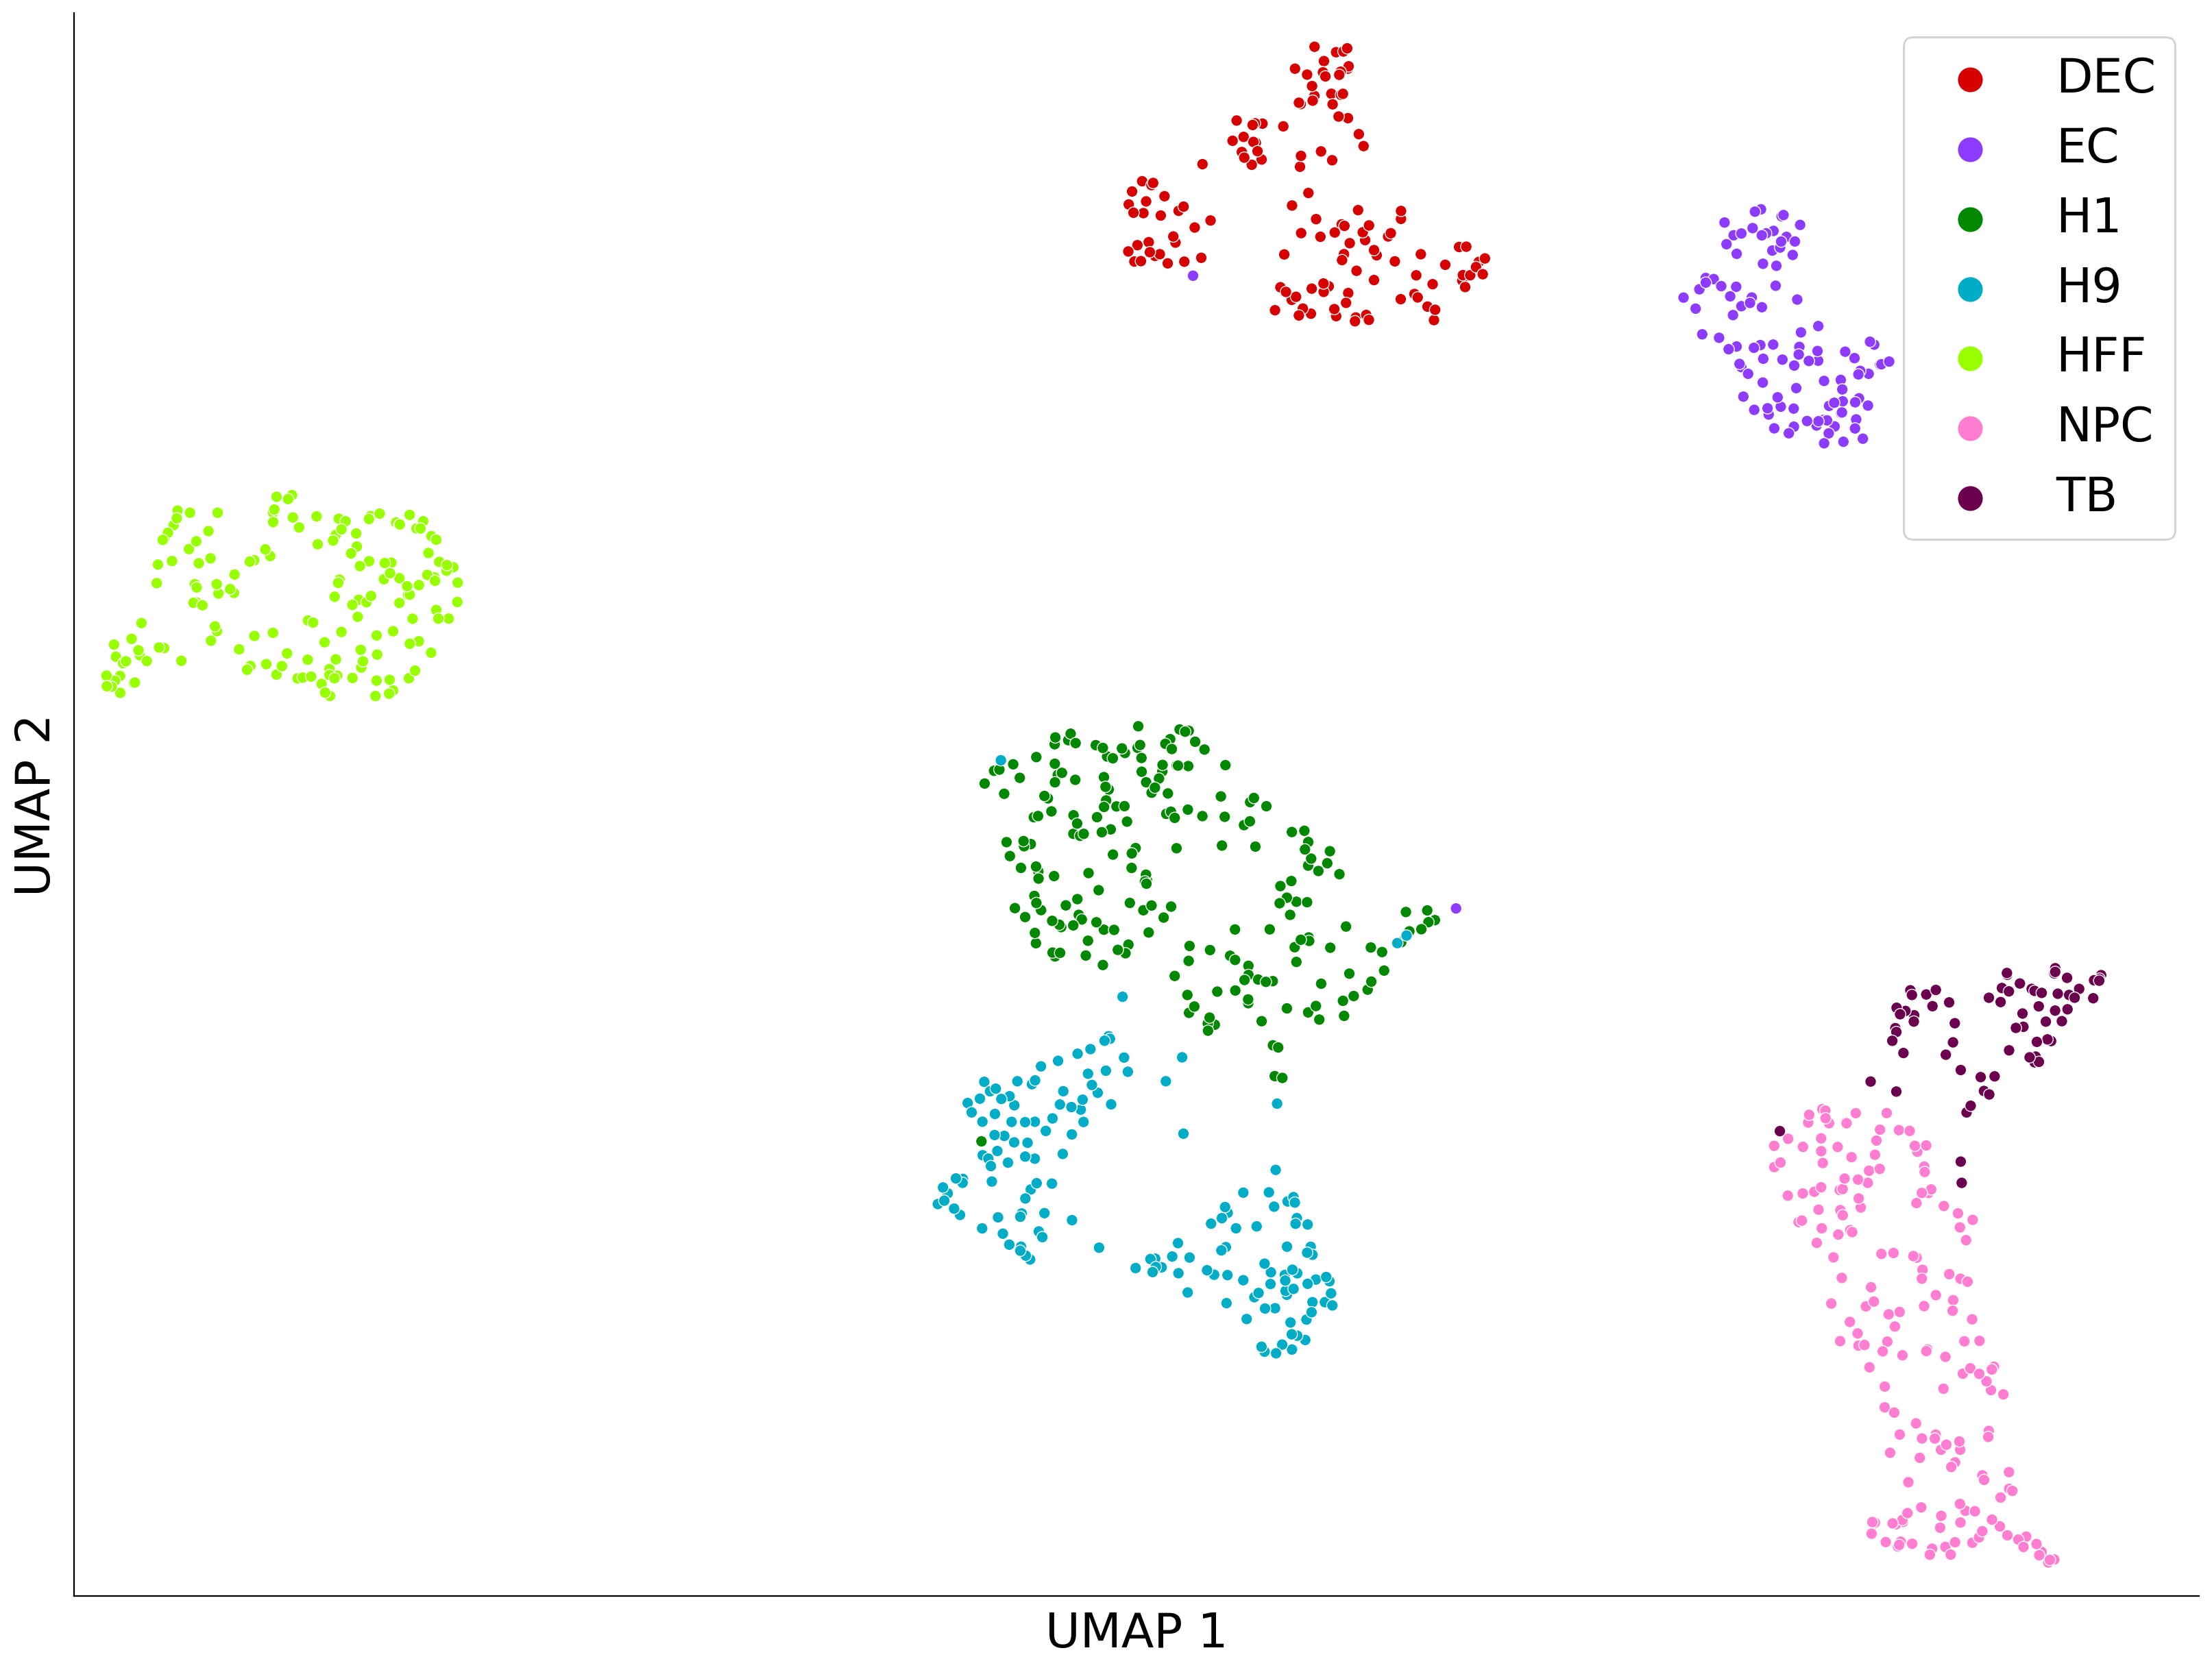

Adjusted Rand Index: 0.8882508768926031
Normalized Mutual Information: 0.9217947501727982
Silhouette Coefficient: 0.6144356727600098


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.8882508768926031, 0.9217947501727982, 0.6144357)

In [50]:
random_seed = [1111,22222,3333,4444,5555,6666,7777,8888,9999]
end_label = [label.split("_")[0] for label in endoderm_scdm.index.to_list()]
calculate_cluster_results(endoderm_scdm.loc[:,adata.var.highly_variable], end_label, 1111)

## Hyperparameter Search
Searching for optimal learning rate and epoch size and batch size

In [40]:
# load endoderm data
dataname = "endoderm/endoderm.csv"
output_dir = None
transpose = True
highly_genes = None
highly_subset=False
adata = prepro(dataname, transpose=transpose)

adata = normalize(adata, highly_genes=highly_genes, highly_subset=highly_subset)
data_label = [label.split("_")[0] for label in adata.obs_names.to_list()]
high_variable = adata.var.highly_variable
input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

learning_rate = [0.0001, 0.001]
batch_size=[256, 128, 64]
pretrain_epoch = [300, 100, 50]

hyper_result= []
for lr in learning_rate:
    for bs in batch_size:
        for epoch in pretrain_epoch:
            if not (lr==0.0001 and bs==256 and epoch==300):
                endoderm = adata.copy()
                # train model
                model = scDMFK(output_dir, input_size, output_size, dims=[64,32,64], learning_rate=lr)
                model.pretrain(endoderm, size_factor, batch_size=bs, pretrain_epoch=epoch, tensorboard=True)
                model.predict(endoderm)
            for mode in ['denoise', 'latent']:
                data = endoderm.X if mode=='denoise' else endoderm.obsm['X_hidden']
                # clustering metrics: all denoised genes
                ari, nmi, sc = calculate_cluster_results(data, data_label, 1111)
                # # only highly_variable genes
                # calculate_cluster_results(endoderm_scdm.loc[:,adata.var.highly_variable], end_label, 1111)
                hyper_result.append([lr, bs, epoch, mode, ari, nmi, sc])
                print(ari, nmi, sc)
pd.DataFrame(hyper_result, columns=['learning rate', 'batch size', 'epochs', 'mode', 'ARI','NMI','SC'])

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6410004795273216
Normalized Mutual Information: 0.7667294249635506
Silhouette Coefficient: 0.5789353847503662
0.6410004795273216 0.7667294249635506 0.5789354


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5681495407474076
Normalized Mutual Information: 0.698629763361789
Silhouette Coefficient: 0.5250184535980225
0.5681495407474076 0.698629763361789 0.52501845
Begin the pretraining...


2024-04-21 14:49:27.076387: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 14:49:27.076660: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 14:49:27.364838: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 14:49:27.372637: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 14:49:27.384878: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256100/plugins/profile/2024_04_21_14_49_27
2024-04-21 14:49:27.387098: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/256100/plugins/profile/2024_04_21_14_49_27/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 14:49:27.403255: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256100/plugins/profile/2024_04_21_14_49_2

Average loss:  2324.5119193922037
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.576790854166142
Normalized Mutual Information: 0.7105014220735482
Silhouette Coefficient: 0.47957703471183777
0.576790854166142 0.7105014220735482 0.47957703


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.4385729779664899
Normalized Mutual Information: 0.5976884004903503
Silhouette Coefficient: 0.48690080642700195
0.4385729779664899 0.5976884004903503 0.4869008
Begin the pretraining...


2024-04-21 14:51:58.065706: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 14:51:58.065749: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 14:51:58.324246: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 14:51:58.327740: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 14:51:58.332737: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/25650/plugins/profile/2024_04_21_14_51_58
2024-04-21 14:51:58.334232: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/25650/plugins/profile/2024_04_21_14_51_58/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 14:51:58.338528: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/25650/plugins/profile/2024_04_21_14_51_58
2

Average loss:  2481.160376090535
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.5926662860418853
Normalized Mutual Information: 0.7148029869094447
Silhouette Coefficient: 0.5347402095794678
0.5926662860418853 0.7148029869094447 0.5347402


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.38496558077636966
Normalized Mutual Information: 0.5143305444413503
Silhouette Coefficient: 0.4650227129459381
0.38496558077636966 0.5143305444413503 0.4650227
Begin the pretraining...


2024-04-21 14:53:39.933866: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 14:53:39.933917: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 14:53:40.075899: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 14:53:40.077764: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 14:53:40.081553: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128300/plugins/profile/2024_04_21_14_53_40
2024-04-21 14:53:40.082651: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/128300/plugins/profile/2024_04_21_14_53_40/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 14:53:40.086397: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128300/plugins/profile/2024_04_21_14_53_4

Average loss:  2147.067743899683
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6310847313516496
Normalized Mutual Information: 0.7787754579661536
Silhouette Coefficient: 0.5689557790756226
0.6310847313516496 0.7787754579661536 0.5689558


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.622812967836742
Normalized Mutual Information: 0.747638922091121
Silhouette Coefficient: 0.5302939414978027
0.622812967836742 0.747638922091121 0.53029394
Begin the pretraining...


2024-04-21 14:59:21.291154: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 14:59:21.291196: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 14:59:21.431715: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 14:59:21.434212: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 14:59:21.436768: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128100/plugins/profile/2024_04_21_14_59_21
2024-04-21 14:59:21.437837: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/128100/plugins/profile/2024_04_21_14_59_21/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 14:59:21.440891: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128100/plugins/profile/2024_04_21_14_59_2

Average loss:  2250.6569020984093
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6332401659645928
Normalized Mutual Information: 0.7596578857528902
Silhouette Coefficient: 0.5933480858802795
0.6332401659645928 0.7596578857528902 0.5933481


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5437581908046513
Normalized Mutual Information: 0.6971037858833464
Silhouette Coefficient: 0.5308065414428711
0.5437581908046513 0.6971037858833464 0.53080654
Begin the pretraining...


2024-04-21 15:01:49.501329: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:01:49.501372: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:01:49.616806: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:01:49.621582: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:01:49.624339: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/12850/plugins/profile/2024_04_21_15_01_49
2024-04-21 15:01:49.625718: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/12850/plugins/profile/2024_04_21_15_01_49/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:01:49.629473: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/12850/plugins/profile/2024_04_21_15_01_49
2

Average loss:  2364.502002834911
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6171318472859969
Normalized Mutual Information: 0.7428277120522758
Silhouette Coefficient: 0.5069876313209534
0.6171318472859969 0.7428277120522758 0.50698763


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5338992516324088
Normalized Mutual Information: 0.6740233228210156
Silhouette Coefficient: 0.5078646540641785
0.5338992516324088 0.6740233228210156 0.50786465
Begin the pretraining...


2024-04-21 15:03:37.568559: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:03:37.568785: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:03:37.634935: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:03:37.636990: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:03:37.640799: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64300/plugins/profile/2024_04_21_15_03_37
2024-04-21 15:03:37.641677: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/64300/plugins/profile/2024_04_21_15_03_37/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:03:37.645185: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64300/plugins/profile/2024_04_21_15_03_37
2

Average loss:  2122.9991733410434
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.7184252797064878
Normalized Mutual Information: 0.840844291982022
Silhouette Coefficient: 0.5737687349319458
0.7184252797064878 0.840844291982022 0.57376873


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6392537841810095
Normalized Mutual Information: 0.7812611357851401
Silhouette Coefficient: 0.5519044995307922
0.6392537841810095 0.7812611357851401 0.5519045
Begin the pretraining...


2024-04-21 15:17:58.918788: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:17:58.918946: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:17:59.002241: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:17:59.004798: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:17:59.007608: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64100/plugins/profile/2024_04_21_15_17_59
2024-04-21 15:17:59.008960: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/64100/plugins/profile/2024_04_21_15_17_59/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:17:59.014203: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64100/plugins/profile/2024_04_21_15_17_59
2

Average loss:  2204.046953556895
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7144228123695315
Normalized Mutual Information: 0.8278661788769297
Silhouette Coefficient: 0.5918964147567749
0.7144228123695315 0.8278661788769297 0.5918964


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.7036262166474763
Normalized Mutual Information: 0.8042446498570335
Silhouette Coefficient: 0.548481822013855
0.7036262166474763 0.8042446498570335 0.5484818
Begin the pretraining...


2024-04-21 15:20:23.199672: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:20:23.199717: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:20:23.284901: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:20:23.286799: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:20:23.290624: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/6450/plugins/profile/2024_04_21_15_20_23
2024-04-21 15:20:23.291563: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/6450/plugins/profile/2024_04_21_15_20_23/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:20:23.295303: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/6450/plugins/profile/2024_04_21_15_20_23
2024

Average loss:  2278.116882060283
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6366321594951498
Normalized Mutual Information: 0.7623548961539707
Silhouette Coefficient: 0.5375158786773682
0.6366321594951498 0.7623548961539707 0.5375159


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.560619471261183
Normalized Mutual Information: 0.685412077987174
Silhouette Coefficient: 0.4971766173839569
0.560619471261183 0.685412077987174 0.49717662
Begin the pretraining...


2024-04-21 15:22:01.528920: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:22:01.528963: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:22:01.743070: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:22:01.746236: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:22:01.749265: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256300/plugins/profile/2024_04_21_15_22_01
2024-04-21 15:22:01.750197: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/256300/plugins/profile/2024_04_21_15_22_01/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:22:01.753541: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256300/plugins/profile/2024_04_21_15_22_0

Average loss:  2092.2364429750687
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7924626021346112
Normalized Mutual Information: 0.8866702493578268
Silhouette Coefficient: 0.682937502861023
0.7924626021346112 0.8866702493578268 0.6829375


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6709080677394367
Normalized Mutual Information: 0.7650174764135613
Silhouette Coefficient: 0.5764737129211426
0.6709080677394367 0.7650174764135613 0.5764737
Begin the pretraining...


2024-04-21 15:27:37.286382: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:27:37.287287: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:27:37.697235: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:27:37.707430: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:27:37.714152: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256100/plugins/profile/2024_04_21_15_27_37
2024-04-21 15:27:37.716282: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/256100/plugins/profile/2024_04_21_15_27_37/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:27:37.726991: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/256100/plugins/profile/2024_04_21_15_27_3

Average loss:  2154.7684361743222
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7028785040453258
Normalized Mutual Information: 0.8335237505737657
Silhouette Coefficient: 0.6282875537872314
0.7028785040453258 0.8335237505737657 0.62828755


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6294542036732935
Normalized Mutual Information: 0.7387372470909729
Silhouette Coefficient: 0.5421333312988281
0.6294542036732935 0.7387372470909729 0.54213333
Begin the pretraining...


2024-04-21 15:30:16.641941: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:30:16.641988: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:30:16.894503: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:30:16.898087: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:30:16.900421: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/25650/plugins/profile/2024_04_21_15_30_16
2024-04-21 15:30:16.901361: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/25650/plugins/profile/2024_04_21_15_30_16/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:30:16.906949: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/25650/plugins/profile/2024_04_21_15_30_16
2

Average loss:  2201.10665250811
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.723347855812337
Normalized Mutual Information: 0.8458460286967867
Silhouette Coefficient: 0.5871989130973816
0.723347855812337 0.8458460286967867 0.5871989


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6104381422378334
Normalized Mutual Information: 0.7462530557239911
Silhouette Coefficient: 0.5938301086425781
0.6104381422378334 0.7462530557239911 0.5938301
Begin the pretraining...


2024-04-21 15:32:06.968984: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:32:06.969029: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:32:07.090307: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:32:07.092479: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:32:07.095251: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128300/plugins/profile/2024_04_21_15_32_07
2024-04-21 15:32:07.096289: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/128300/plugins/profile/2024_04_21_15_32_07/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:32:07.100501: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128300/plugins/profile/2024_04_21_15_32_0

Average loss:  2080.7249812365635
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7234637417452651
Normalized Mutual Information: 0.8344046722703012
Silhouette Coefficient: 0.5984143614768982
0.7234637417452651 0.8344046722703012 0.59841436


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6403378620263773
Normalized Mutual Information: 0.7649379877843395
Silhouette Coefficient: 0.5173547267913818
0.6403378620263773 0.7649379877843395 0.5173547
Begin the pretraining...


2024-04-21 15:38:00.380277: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:38:00.380349: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:38:00.508982: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:38:00.510925: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:38:00.513508: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128100/plugins/profile/2024_04_21_15_38_00
2024-04-21 15:38:00.514742: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/128100/plugins/profile/2024_04_21_15_38_00/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:38:00.518933: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/128100/plugins/profile/2024_04_21_15_38_0

Average loss:  2125.8887725755094
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6826861030904241
Normalized Mutual Information: 0.8207748711093006
Silhouette Coefficient: 0.6340242028236389
0.6826861030904241 0.8207748711093006 0.6340242


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6567571478516354
Normalized Mutual Information: 0.7676338001704752
Silhouette Coefficient: 0.5330774784088135
0.6567571478516354 0.7676338001704752 0.5330775
Begin the pretraining...


2024-04-21 15:40:31.197378: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:40:31.197440: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:40:31.310767: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:40:31.312787: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:40:31.314624: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/12850/plugins/profile/2024_04_21_15_40_31
2024-04-21 15:40:31.315681: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/12850/plugins/profile/2024_04_21_15_40_31/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:40:31.318926: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/12850/plugins/profile/2024_04_21_15_40_31
2

Average loss:  2173.83243153865
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.6561189359230618
Normalized Mutual Information: 0.8158769623249146
Silhouette Coefficient: 0.6111984848976135
0.6561189359230618 0.8158769623249146 0.6111985


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5888364452609487
Normalized Mutual Information: 0.7362779748326651
Silhouette Coefficient: 0.5432433485984802
0.5888364452609487 0.7362779748326651 0.54324335
Begin the pretraining...


2024-04-21 15:42:27.280309: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:42:27.281266: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:42:27.378622: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:42:27.380542: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:42:27.383240: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64300/plugins/profile/2024_04_21_15_42_27
2024-04-21 15:42:27.384155: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/64300/plugins/profile/2024_04_21_15_42_27/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:42:27.388171: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64300/plugins/profile/2024_04_21_15_42_27
2

Average loss:  2104.684213305324
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7670263106458354
Normalized Mutual Information: 0.8671183054400738
Silhouette Coefficient: 0.6255797743797302
0.7670263106458354 0.8671183054400738 0.6255798


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.6821990852638848
Normalized Mutual Information: 0.7910867913533101
Silhouette Coefficient: 0.5717501044273376
0.6821990852638848 0.7910867913533101 0.5717501
Begin the pretraining...


2024-04-21 15:47:40.660009: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:47:40.660056: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:47:40.780608: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:47:40.782637: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:47:40.785087: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64100/plugins/profile/2024_04_21_15_47_40
2024-04-21 15:47:40.786329: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/64100/plugins/profile/2024_04_21_15_47_40/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:47:40.789962: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/64100/plugins/profile/2024_04_21_15_47_40
2

Average loss:  2147.9831871478855
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.9406229948836696
Normalized Mutual Information: 0.9471687068707904
Silhouette Coefficient: 0.6219128370285034
0.9406229948836696 0.9471687068707904 0.62191284


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.5933360400435851
Normalized Mutual Information: 0.7287972556710064
Silhouette Coefficient: 0.5421868562698364
0.5933360400435851 0.7287972556710064 0.54218686
Begin the pretraining...


2024-04-21 15:50:14.759667: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2024-04-21 15:50:14.759713: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2024-04-21 15:50:14.835288: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2024-04-21 15:50:14.838686: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2024-04-21 15:50:14.843195: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/6450/plugins/profile/2024_04_21_15_50_14
2024-04-21 15:50:14.844120: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to results/tb/6450/plugins/profile/2024_04_21_15_50_14/YufeideMacBook-Pro.local.trace.json.gz
2024-04-21 15:50:14.849516: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: results/tb/6450/plugins/profile/2024_04_21_15_50_14
2024

Average loss:  2158.300345210045
Calculating reconstructions...
Calculating hidden representation...


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adjusted Rand Index: 0.7298129454388979
Normalized Mutual Information: 0.8372610201886169
Silhouette Coefficient: 0.6081847548484802
0.7298129454388979 0.8372610201886169 0.60818475
Adjusted Rand Index: 0.6429615276124758
Normalized Mutual Information: 0.7536973011961531
Silhouette Coefficient: 0.553936243057251
0.6429615276124758 0.7536973011961531 0.55393624


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


learning rate  batch size  epochs     mode       ARI       NMI        SC
0          0.0001         256     300  denoise  0.641000  0.766729  0.578935
1          0.0001         256     300   latent  0.568150  0.698630  0.525018
2          0.0001         256     100  denoise  0.576791  0.710501  0.479577
3          0.0001         256     100   latent  0.438573  0.597688  0.486901
4          0.0001         256      50  denoise  0.592666  0.714803  0.534740
5          0.0001         256      50   latent  0.384966  0.514331  0.465023
6          0.0001         128     300  denoise  0.631085  0.778775  0.568956
7          0.0001         128     300   latent  0.622813  0.747639  0.530294
8          0.0001         128     100  denoise  0.633240  0.759658  0.593348
9          0.0001         128     100   latent  0.543758  0.697104  0.530807
10         0.0001         128      50  denoise  0.617132  0.742828  0.506988
11         0.0001         128      50   latent  0.533899  0.674023  0.507865
12         0.0001          64     300  denoise  0.718425  0.840844  0.573769
13         0.0001          64     300   latent  0.639254  0.781261  0.551904
14         0.0001          64     100  denoise  0.714423  0.827866  0.591896
15         0.0001          64     100   latent  0.703626  0.804245  0.548482
16         0.0001          64      50  denoise  0.636632  0.762355  0.537516
17         0.0001          64      50   latent  0.560619  0.685412  0.497177
18         0.0010         256     300  denoise  0.792463  0.886670  0.682938
19         0.0010         256     300   latent  0.670908  0.765017  0.576474
20         0.0010         256     100  denoise  0.702879  0.833524  0.628288
21         0.0010         256     100   latent  0.629454  0.738737  0.542133
22         0.0010         256      50  denoise  0.723348  0.845846  0.587199
23         0.0010         256      50   latent  0.610438  0.746253  0.593830
24         0.0010         128     300  denoise  0.723464  0.834405  0.598414
25         0.0010         128     300   latent  0.640338  0.764938  0.517355
26         0.0010         128     100  denoise  0.682686  0.820775  0.634024
27         0.0010         128     100   latent  0.656757  0.767634  0.533077
28         0.0010         128      50  denoise  0.656119  0.815877  0.611198
29         0.0010         128      50   latent  0.588836  0.736278  0.543243
30         0.0010          64     300  denoise  0.767026  0.867118  0.625580
31         0.0010          64     300   latent  0.682199  0.791087  0.571750
32         0.0010          64     100  denoise  0.940623  0.947169  0.621913
33         0.0010          64     100   latent  0.593336  0.728797  0.542187
34         0.0010          64      50  denoise  0.729813  0.837261  0.608185
35         0.0010          64      50   latent  0.642962  0.753697  0.553936

In [47]:
hyper_result = pd.DataFrame(hyper_result, columns=['learning rate', 'batch size', 'epochs', 'mode', 'ARI','NMI','SC'])
hyper_result.sort_values(by=['mode','learning rate'])
# hyper_result.to_csv('results/hyper-search.csv')

learning rate  batch size  epochs     mode       ARI       NMI        SC
0          0.0001         256     300  denoise  0.641000  0.766729  0.578935
2          0.0001         256     100  denoise  0.576791  0.710501  0.479577
4          0.0001         256      50  denoise  0.592666  0.714803  0.534740
6          0.0001         128     300  denoise  0.631085  0.778775  0.568956
8          0.0001         128     100  denoise  0.633240  0.759658  0.593348
10         0.0001         128      50  denoise  0.617132  0.742828  0.506988
12         0.0001          64     300  denoise  0.718425  0.840844  0.573769
14         0.0001          64     100  denoise  0.714423  0.827866  0.591896
16         0.0001          64      50  denoise  0.636632  0.762355  0.537516
18         0.0010         256     300  denoise  0.792463  0.886670  0.682938
20         0.0010         256     100  denoise  0.702879  0.833524  0.628288
22         0.0010         256      50  denoise  0.723348  0.845846  0.587199
24         0.0010         128     300  denoise  0.723464  0.834405  0.598414
26         0.0010         128     100  denoise  0.682686  0.820775  0.634024
28         0.0010         128      50  denoise  0.656119  0.815877  0.611198
30         0.0010          64     300  denoise  0.767026  0.867118  0.625580
32         0.0010          64     100  denoise  0.940623  0.947169  0.621913
34         0.0010          64      50  denoise  0.729813  0.837261  0.608185
1          0.0001         256     300   latent  0.568150  0.698630  0.525018
3          0.0001         256     100   latent  0.438573  0.597688  0.486901
5          0.0001         256      50   latent  0.384966  0.514331  0.465023
7          0.0001         128     300   latent  0.622813  0.747639  0.530294
9          0.0001         128     100   latent  0.543758  0.697104  0.530807
11         0.0001         128      50   latent  0.533899  0.674023  0.507865
13         0.0001          64     300   latent  0.639254  0.781261  0.551904
15         0.0001          64     100   latent  0.703626  0.804245  0.548482
17         0.0001          64      50   latent  0.560619  0.685412  0.497177
19         0.0010         256     300   latent  0.670908  0.765017  0.576474
21         0.0010         256     100   latent  0.629454  0.738737  0.542133
23         0.0010         256      50   latent  0.610438  0.746253  0.593830
25         0.0010         128     300   latent  0.640338  0.764938  0.517355
27         0.0010         128     100   latent  0.656757  0.767634  0.533077
29         0.0010         128      50   latent  0.588836  0.736278  0.543243
31         0.0010          64     300   latent  0.682199  0.791087  0.571750
33         0.0010          64     100   latent  0.593336  0.728797  0.542187
35         0.0010          64      50   latent  0.642962  0.753697  0.553936

In [34]:
# hyper_result = pd.read_csv('results/hyper-search.csv', index_col=0)
hyper_result[['ARI','NMI','SC']] = hyper_result[['ARI','NMI','SC']].astype('float32')
hyper_result[['epochs']] = hyper_result[['epochs']].astype('str')
hyper_result[hyper_result['mode']=='denoise'].sort_values(by='ARI')#.groupby(['learning rate','batch size']).mean()


learning rate  batch size epochs     mode       ARI       NMI        SC
2          0.0001         256    100  denoise  0.576791  0.710501  0.479577
4          0.0001         256     50  denoise  0.592666  0.714803  0.534740
10         0.0001         128     50  denoise  0.617132  0.742828  0.506988
6          0.0001         128    300  denoise  0.631085  0.778775  0.568956
8          0.0001         128    100  denoise  0.633240  0.759658  0.593348
16         0.0001          64     50  denoise  0.636632  0.762355  0.537516
0          0.0001         256    300  denoise  0.641001  0.766729  0.578935
28         0.0010         128     50  denoise  0.656119  0.815877  0.611198
26         0.0010         128    100  denoise  0.682686  0.820775  0.634024
20         0.0010         256    100  denoise  0.702878  0.833524  0.628288
14         0.0001          64    100  denoise  0.714423  0.827866  0.591896
12         0.0001          64    300  denoise  0.718425  0.840844  0.573769
22         0.0010         256     50  denoise  0.723348  0.845846  0.587199
24         0.0010         128    300  denoise  0.723464  0.834405  0.598414
34         0.0010          64     50  denoise  0.729813  0.837261  0.608185
30         0.0010          64    300  denoise  0.767026  0.867118  0.625580
18         0.0010         256    300  denoise  0.792463  0.886670  0.682938
32         0.0010          64    100  denoise  0.940623  0.947169  0.621913